# NEAT - NeuroEvolution of Augmenting Topologies

## Motivation and idea

Most neural networks are trained using gradient-based optimization like backpropagation. This approach requires:
- Differentiable activation functions,
- Continuous loss functions,
- Fixed network topology.

Many problems, especially those involving control, sparse or delayed rewards, or discrete decision-making like some reinforcement learning problems make gradient-based training difficult or unstable.

Neuroevolution offers an alternative: instead of adjusting weights using gradients, we treat the entire network as an individual in a population and proceed to evole the population (network topologies, weights or both) using standard principles of genetic algorithms - selection, crossover, mutations.

In essence, instead of optimizing the netwarks using calculus we search for good networks using a genetic algorithm.

## NEAT

NEAT is a neuroevolution algorithm designed to evolve both weights and topology of the network introduced by Kenneth O. Stanley & Risto Miikkulainen in their paper [Efficient Evolution of Neural Network Topologies](https://nn.cs.utexas.edu/downloads/papers/stanley.cec02.pdf).

NEAT works by maintaining a popolation of neural networks, each with its own topology and weights. These networks are evaluated on a given task, assigned a fitness score and then selectively bred through crossover and mutation to form the next generation of networks.

The key ideas that make NEAT different compared to standard genetic algorithms or other neuroevolution algorithms are historical markings, where every new topological innovation receives a unique innovation number, making it possible to align different network topologies during crossover without confusion, and the idea to protect innovation, i.e maintaining diversity by letting newly mutated networks have time to prove their worth by only comparing them within their own species before competing globally.

### Genotype representation in NEAT

Each netowrk in NEAT can be represented as a genotype containing a list of node genes and connection genes. Node genes containing information about network nodes, connection genes containing information about connectins such as input node, output node, connection weight.

<center><img src="./images/genotype.png"/></center>

The mapping from genotype to phenotype is deterministic: every gene precisely defines how the corresponding network will be structured and behave.

### Historical markings (innovation numbers) and crossover

A central concept that makes NEAT efficient and stable during evolution is its system of historical markings. These numbers serve as a unique record of how each structural feature of a network came into existence.

When a new structural mutation occurs NEAT assigns it a new innovation number. This number acts like a genetic timestamp that records the order of discovery for every new connection gene.

Without innovation numbers, it would be difficult to align genes between two parent networks during crossover, especially when their topologies differ. NEAT uses innovation numbers to ensure that corresponding genes from different genomes can be matched correctly, even if the networks have evolved independently for many generations.

--------------

When two genomes reproduce, NEAT aligns their genes using innovation numbers. Genes are classified as:
- Matching: present in both parents (same innovation ID).
- Disjoint: present in one parent but missing in the middle of the other’s innovation range.
- Excess: present in one parent but beyond the other’s maximum innovation ID.

The offspring inherits matching genes randomly and nonmatching genes from the fitter parent. This preserves meaningful structure during crossover, even when networks differ in size or shape.

For example:
<center><img src="images/markings.png"/></center>
Here, although Parent 1 and Parent 2 look different, their innovation numbers (shown at the top of each gene) tell us which genes match up with which without the need for topological analysis.

### Mutations

Mutation in NEAT can change both connection weights and network structures. 

Connection weights mutate as in any NE system, with each connection either perturbed or not.
$$ w' = w + \mathcal{N}(0, \sigma^{2}) $$

Structural mutations, which expand the genome, occur in two ways:
- In the add connection mutation, a single new connection gene is added connecting two previously unconnected nodes <center><img src="images/add_connection.png"/></center>
- In the add node mutation an existing connection is split and the new node placed where the old connection used to be. The old connection is disabled and two new connections are added to the genome. <center><img src="images/add_node.png"/></center>

### Speciation and compatibility distance

To prevent new, innovative structures from being immediately outcompeted by older, optimized ones, NEAT groups similar genomes into species. Within a species, individuals compete only with each other.

Similarity is measured by compatibility distance:

$$ \delta(g_{a}, g_{b}) = \frac{c_{1}E(g_{a}, g_{b})}{N} + \frac{c_{2}D(g_{a}, g_{b})}{N} + c_{3}\overline{W}(g_{a}, g_{b}) $$

Where:
- $E(g_{a}, g_{b})$ - Excess genes
- $D(g_{a}, g_{b})$ - Disjoint genes
- $\overline{W}(g_{a}, g_{b})$ - average weight difference of matching genes
- $N$ - Number of genes in the larger genome
- $c_{1}, c_{2}, c_{3}$ - importance factors

Two networks belong to the same species if $\delta < \delta_{threshold}$. Every genome is placed into the first species for which this condition is satisfied, so that no network can belong to two different species.


The size of each species is determined by comparing averge fitness of the species compared to global population fitness, i.e at each step the size of given species is determined by the following formula:

$$ N'_{j} = \frac{\sum_{i=1}^{N_{j}}f_{ij}}{f} $$

Where:
- $N_{j}$ and $N'_{j}$ are the old and new number of individuals in species j
- $f_{ij}$ is the adjusted fitness of individual $i$ in species $j$
- $f$ is the mean adjusted fitness in the entire population

During crossover the best performing $r\%$ of each species is randomly mated to generate $N'_{j}$ offspring, which replaces the entire population of the species.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import time
import neat
import visualize

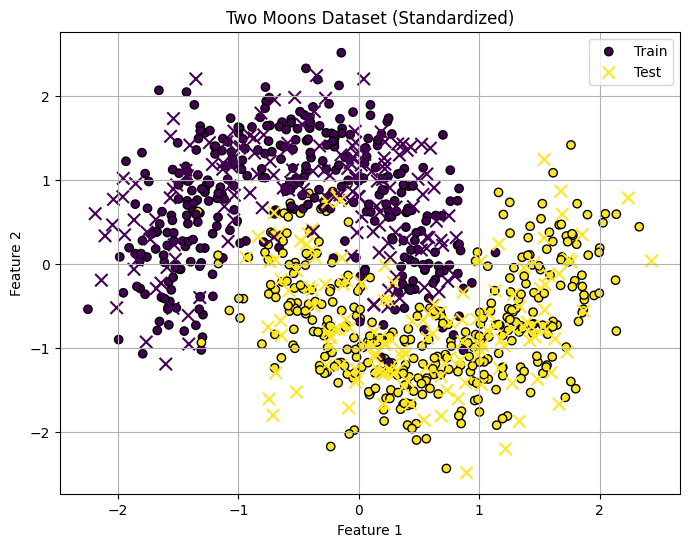

Training set shape: X=(700, 2), y=(700,)
Test set shape: X=(300, 2), y=(300,)


In [2]:
X, y = make_moons(n_samples=1000, noise=0.25, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, edgecolors="k", label="Train"
)
plt.scatter(
    X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test, marker="x", s=80, label="Test"
)
plt.title("Two Moons Dataset (Standardized)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

print(f"Training set shape: X={X_train_scaled.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_test_scaled.shape}, y={y_test.shape}")



In [3]:
def fitness_function(nn_output: np.ndarray, true_data: np.ndarray) -> np.ndarray:
    accuracy = (nn_output == true_data).astype(float).mean()
    return accuracy

In [4]:
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        outputs = np.array([net.activate(x)[0] > 0.5 for x in X_train]).astype(int)
        genome.fitness = fitness_function(outputs, y_train)

In [5]:
def run(config_filename):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation, config_filename)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))

    # Run for up to 300 generations.
    winner = p.run(eval_genomes, 300)

    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))

    # Show output of the most fit genome against training data.
    print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    for xi, xo in zip(X_test, y_test):
        output = winner_net.activate(xi)
        print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

    p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
    p.run(eval_genomes, 10)
    return winner, stats

In [6]:
winner, stats = run('config')


 ****** Running generation 0 ****** 

Population's average fitness: 0.49420 stdev: 0.18859
Best fitness: 0.85429 - size: (1, 2) - species 1 - id 86
Average adjusted fitness: 0.334
Mean genetic distance 1.117, standard deviation 0.432
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   150      0.9    0.334     0
Total extinctions: 0
Generation time: 0.128 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.63703 stdev: 0.15026
Best fitness: 0.85429 - size: (1, 2) - species 1 - id 86
Average adjusted fitness: 0.423
Mean genetic distance 1.178, standard deviation 0.499
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   150      0.9    0.423     1
Total extinctions: 0
Generation time: 0.137 sec (0.132 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.66907 stdev: 0.

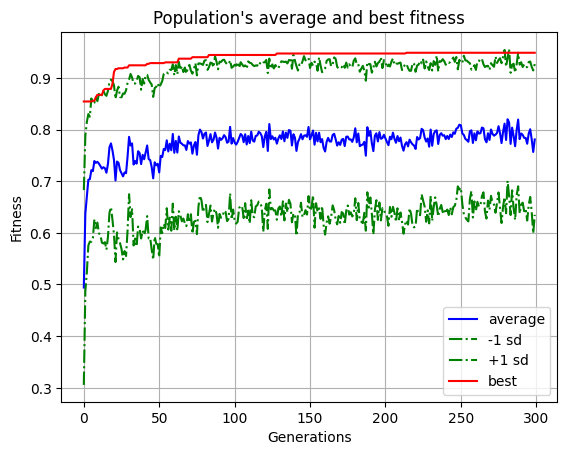

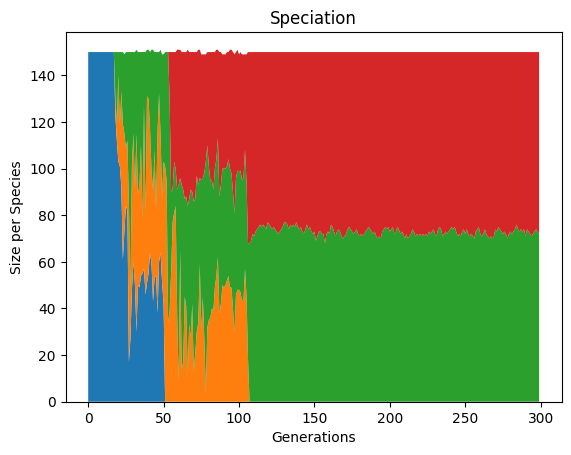

In [7]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation, 'config')
node_names = {-1: 'x', -2: 'y'}
visualize.draw_net(config, winner, True, node_names=node_names)

visualize.plot_stats(stats, ylog=False, view=True)

visualize.plot_species(stats, view=True) 

# Reinforcement learning example

## CartPole

In [8]:
import os
from typing import Any
import torch
import gymnasium as gym
from tqdm import tqdm
import neat
import visualize
import imageio
import numpy as np
import pickle
print(torch.cuda.is_available())

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
N_EXPERIMENTS = 10

OUTPUT_DIR = "reinforcement/cartpole"
os.makedirs(OUTPUT_DIR, exist_ok=True)


def run_with_single_net(net: Any, environment, record_gif: bool = False, gif_name: str = None, max_steps=5000):
    reward_sum = 0.0
    frames = []

    for _ in range(N_EXPERIMENTS):
        done = False
        state, info = environment.reset()
        step = 0
        while not done:
            if record_gif:
                frame = environment.render()
                if isinstance(frame, np.ndarray):
                    frames.append(frame)
            output = net.activate(state)
            action = max(enumerate(output), key=lambda x: x[1])[0]
            state, reward, done, truncated, info = environment.step(action)
            step += 1
            reward_sum += reward
            if step >= max_steps:
                break

    if record_gif and gif_name and frames:
        gif_path = os.path.join(OUTPUT_DIR, gif_name)
        imageio.mimsave(gif_path, frames, fps=30)

    return reward_sum / N_EXPERIMENTS


def eval_genomes(genomes, config, environment, max_steps=5000):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = run_with_single_net(net, environment, max_steps=max_steps)


def main(config_filename) -> None:
    environment = gym.make('CartPole-v1', render_mode='rgb_array')
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation, config_filename)

    p = neat.Population(config)
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))


    winner = p.run(lambda g, c: eval_genomes(g, c, environment, 5e3), 500)

    print('\nBest genome:\n{!s}'.format(winner))
    with open(f"{OUTPUT_DIR}/winner_genome.pkl", "wb") as f:
        pickle.dump(winner, f)

    visualize.draw_net(config, winner, view=False, filename=os.path.join(OUTPUT_DIR, 'best_network'))
    visualize.plot_stats(stats, ylog=False, view=False, filename=os.path.join(OUTPUT_DIR, 'fitness_progress.svg'))
    visualize.plot_species(stats, view=False, filename=os.path.join(OUTPUT_DIR, 'species_evolution.svg'))

    print(f"results saved in '{OUTPUT_DIR}' directory")
    environment.close()



main("config_cartpole")

True

 ****** Running generation 0 ****** 

Population's average fitness: 30.97300 stdev: 231.52466
Best fitness: 4019.80000 - size: (2, 8) - species 1 - id 73
Average adjusted fitness: 0.006
Mean genetic distance 0.971, standard deviation 0.285
Population of 300 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   300   4019.8    0.006     0
Total extinctions: 0
Generation time: 0.640 sec

 ****** Running generation 1 ****** 

Population's average fitness: 53.34667 stdev: 216.19751
Best fitness: 3530.30000 - size: (2, 8) - species 1 - id 73
Average adjusted fitness: 0.013
Mean genetic distance 1.042, standard deviation 0.361
Population of 300 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   300   3530.3    0.013     1
Total extinctions: 0
Generation time: 1.083 sec (0.861 average)

 ****** Running generation 2 ****** 

Population's average fitness: 

In [12]:
with open("reinforcement/cartpole/winner_genome.pkl", "rb") as f:
    winner = pickle.load(f)

config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    "config_cartpole"
)

net = neat.nn.FeedForwardNetwork.create(winner, config)

env = gym.make('CartPole-v1', render_mode='human')
state, _ = env.reset()
done = False
while not done:
    env.render()
    output = net.activate(state)
    action = max(enumerate(output), key=lambda x: x[1])[0]
    state, reward, done, truncated, info = env.step(action)

env.close()

KeyboardInterrupt: 

In [6]:
import os
from typing import Any
import torch
import gymnasium as gym
from tqdm import tqdm
import neat
import visualize
import imageio
import numpy as np
import pickle
print(torch.cuda.is_available())

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
N_EXPERIMENTS = 10

OUTPUT_DIR = "reinforcement/lander"
os.makedirs(OUTPUT_DIR, exist_ok=True)


def run_with_single_net(net: Any, environment, record_gif: bool = False, gif_name: str = None, max_steps=5000):
    reward_sum = 0.0
    frames = []

    for _ in range(N_EXPERIMENTS):
        done = False
        state, info = environment.reset()
        step = 0
        while not done:
            if record_gif:
                frame = environment.render()
                if isinstance(frame, np.ndarray):
                    frames.append(frame)
            output = net.activate(state)
            action = max(enumerate(output), key=lambda x: x[1])[0]
            state, reward, done, truncated, info = environment.step(action)
            step += 1
            reward_sum += reward
            if step >= max_steps or reward < -200:
                break

    if record_gif and gif_name and frames:
        gif_path = os.path.join(OUTPUT_DIR, gif_name)
        imageio.mimsave(gif_path, frames, fps=30)

    return reward_sum / N_EXPERIMENTS


def eval_genomes(genomes, config, environment, max_steps=5000):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = run_with_single_net(net, environment, max_steps=max_steps)


def main(config_filename) -> None:
    environment = gym.make('LunarLander-v3')
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation, config_filename)

    p = neat.Population(config)
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))


    winner = p.run(lambda g, c: eval_genomes(g, c, environment, 5e3), 500)

    print('\nBest genome:\n{!s}'.format(winner))
    with open(f"{OUTPUT_DIR}/winner_genome.pkl", "wb") as f:
        pickle.dump(winner, f)

    visualize.draw_net(config, winner, view=False, filename=os.path.join(OUTPUT_DIR, 'best_network'), node_names=node_names)
    visualize.plot_stats(stats, ylog=False, view=False, filename=os.path.join(OUTPUT_DIR, 'fitness_progress.svg'))
    visualize.plot_species(stats, view=False, filename=os.path.join(OUTPUT_DIR, 'species_evolution.svg'))

    print(f"results saved in '{OUTPUT_DIR}' directory")
    environment.close()


#main("config_lunar_lander")


True


In [7]:
OUTPUT_DIR = "reinforcement/lander"

def continue_training_from_checkpoint(checkpoint_path: str, config_filename: str, generations: int = 100):
    print(f"Restoring population from checkpoint: {checkpoint_path}")
    environment = gym.make('LunarLander-v3')

    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation, config_filename)

    p = neat.Checkpointer.restore_checkpoint(checkpoint_path)

    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))

    winner = p.run(lambda g, c: eval_genomes(g, c, environment, 5e3), generations)

    print('\nBest genome:\n{!s}'.format(winner))

    with open(f"{OUTPUT_DIR}/winner_genome_continued.pkl", "wb") as f:
        pickle.dump(winner, f)

    visualize.draw_net(config, winner, view=False, filename=os.path.join(OUTPUT_DIR, 'best_network_continued'))
    visualize.plot_stats(stats, ylog=False, view=False, filename=os.path.join(OUTPUT_DIR, 'fitness_progress_continued.svg'))
    visualize.plot_species(stats, view=False, filename=os.path.join(OUTPUT_DIR, 'species_evolution_continued.svg'))

    print(f"results saved in '{OUTPUT_DIR}' directory")
    environment.close()

continue_training_from_checkpoint("reinforcement/lander0/neat-checkpoint-19", "config_lunar_lander")

Restoring population from checkpoint: reinforcement/lander0/neat-checkpoint-19

 ****** Running generation 19 ****** 

Population's average fitness: -142.67920 stdev: 153.78394
Best fitness: 86.32702 - size: (7, 22) - species 1 - id 4127
Average adjusted fitness: 0.835
Mean genetic distance 1.817, standard deviation 0.217
Population of 200 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   19   200     86.3    0.835     1
Total extinctions: 0
Generation time: 8.915 sec
Saving checkpoint to neat-checkpoint-19

 ****** Running generation 20 ****** 

Population's average fitness: -119.17580 stdev: 116.84045
Best fitness: 213.70025 - size: (6, 22) - species 1 - id 94

Best individual in generation 20 meets fitness threshold - complexity: (6, 22)

Best genome:
Key: 94
Fitness: 213.7002504028761
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.7038137932890833, response=1.0, activation=relu, aggregation=sum)
	1 DefaultNodeGene(key=1, bi

In [9]:
with open("reinforcement/lander/winner_genome_continued.pkl", "rb") as f:
    winner = pickle.load(f)

config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    "config_lunar_lander"
)

net = neat.nn.FeedForwardNetwork.create(winner, config)

env = gym.make('LunarLander-v3', render_mode='human')
state, _ = env.reset()
done = False
while not done:
    env.render()
    output = net.activate(state)
    action = max(enumerate(output), key=lambda x: x[1])[0]
    state, reward, done, truncated, info = env.step(action)

env.close()